In [2]:
 seed = 3301
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(seed)


# Para preparar los datos
# ------------------------
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 



from sklearn.preprocessing import LabelEncoder


# q-q plots
import scipy.stats as stats
import datetime

from langdetect import detect



In [3]:
# Se cargan los datos. 
df=pd.read_csv('mbsa.csv',  delimiter=",", header=0)
# Cantidad de datos y número de variables
df.shape

(19344048, 3)

In [5]:
# Mostrar los datos
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [6]:

df.describe()

,Date,text,Sentiment
count,19344048,19344032,18452904
unique,1917,14876178,3
top,2018-08-03,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,Negative
freq,995986,891106,9729297


In [7]:
dft = df.sample(50000)

In [8]:
# Se estandariza la informacion

# funcion para asignar idioma
def getLanguage (row):
    try:
        return detect(row['text'])
    except:
        return ''

# filtrar por idoma
dft['language']=dft.apply (lambda row: getLanguage(row), axis=1)
dft=dft[dft['language']=='en']



dft['Sentiment'].replace({'Positive':1, 'Negative':0}, inplace = True)
dft=dft[dft['Sentiment'].isin([1,0])]

In [9]:
def is_date(dates):
    result = []
    for date in dates:
        try: 
            datetime.datetime.strptime(date, '%Y-%m-%d')
            result.append(date)
        except ValueError:
            a=''
    return result

validDates = is_date(dft['Date'])

dft=dft[dft['Date'].isin(validDates)]

In [10]:
dft.shape

(33980, 4)

In [11]:
pd.value_counts(dft['Sentiment'])

0.0    17327
1.0    16653
Name: Sentiment, dtype: int64

In [12]:
dft.head()

,Date,text,Sentiment,language
16020949,2019-09-28,$btc #bitcoin | 1H\n\n#IchiEMAPrime Setup. We'...,0.0,en
1282301,2019-05-12,What a beautiful sight to see. I’m actually em...,0.0,en
5807147,2019-05-30,"Principal and Lead, BPO Advisory Practice - Lo...",0.0,en
12787632,2019-08-12,"Price Update: 1 #Bitcoin = $11,548.63 📈 \n\n#c...",0.0,en
13680025,2019-08-25,Get #Bitcoin in your wallet every day even whe...,0.0,en


In [13]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def labelWeekDay (row):
    return datetime.datetime.strptime(row['Date'], '%Y-%m-%d').weekday()
     
dft['weekday_label']=dft.apply (lambda row: labelWeekDay(row), axis=1)



In [14]:
dft_model=dft.copy()

In [15]:
# Mostrar los datos
dft_model.head()

,Date,text,Sentiment,language,weekday_label
16020949,2019-09-28,$btc #bitcoin | 1H\n\n#IchiEMAPrime Setup. We'...,0.0,en,5
1282301,2019-05-12,What a beautiful sight to see. I’m actually em...,0.0,en,6
5807147,2019-05-30,"Principal and Lead, BPO Advisory Practice - Lo...",0.0,en,3
12787632,2019-08-12,"Price Update: 1 #Bitcoin = $11,548.63 📈 \n\n#c...",0.0,en,0
13680025,2019-08-25,Get #Bitcoin in your wallet every day even whe...,0.0,en,6


In [16]:
def labelKeyWord(row,word):
    return row['text'].count(word)

keyWords=['bitcoin','$','buy','get','use','blockchain','market','crypto','time','price','wallet','transact','exchange', 'cryptocurr']

for word in keyWords:
    dft_model[word]=dft_model.apply (lambda row: labelKeyWord(row, word), axis=1)

In [17]:
dft_model = dft_model.drop(['text', 'Date', 'language'], axis=1)
dft_model.head()

,Sentiment,weekday_label,bitcoin,$,buy,get,use,blockchain,market,crypto,time,price,wallet,transact,exchange,cryptocurr
16020949,0.0,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1282301,0.0,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0
5807147,0.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12787632,0.0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,1
13680025,0.0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
dft.shape

(33980, 5)

In [19]:
# Se selecciona la variable objetivo, en este caso "Sentiment".
Y = dft_model['Sentiment']
# Del conjunto de datos se elimina la variable "Sentiment"
X = dft_model.drop(['Sentiment'], axis=1)

In [20]:
#Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [22]:
neigh = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski', p = 2)
neigh = neigh.fit(X_train, Y_train)

In [23]:
y_pred = neigh.predict(X_test)

In [24]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred)

array([[2117, 1333],
       [1750, 1596]], dtype=int64)

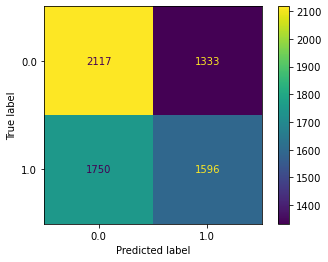

In [25]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(neigh, X_test, Y_test)  
plt.show()

In [26]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.61      0.58      3450
         1.0       0.54      0.48      0.51      3346

    accuracy                           0.55      6796
   macro avg       0.55      0.55      0.54      6796
weighted avg       0.55      0.55      0.54      6796



In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,10))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
mejor_modelo_knn.fit(X_train, Y_train)

#Print The value of best Hyperparameters
print('Best p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])

Best p: 1
Best n_neighbors: 9


In [28]:
# Obtener el mejor modelo.
neigh_final = mejor_modelo_knn.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = neigh_final.predict(X_train)
y_pred_test = neigh_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.58
Exactitud sobre test: 0.54


In [29]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.54      0.69      0.60      3450
         1.0       0.55      0.40      0.46      3346

    accuracy                           0.54      6796
   macro avg       0.54      0.54      0.53      6796
weighted avg       0.54      0.54      0.53      6796



In [34]:
neigh = KNeighborsClassifier(n_neighbors=9, metric = 'manhattan', p = 1)
neigh = neigh.fit(X_train, Y_train)

In [35]:
y_pred = neigh.predict(X_test)

In [36]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred)

array([[2368, 1082],
       [2022, 1324]], dtype=int64)

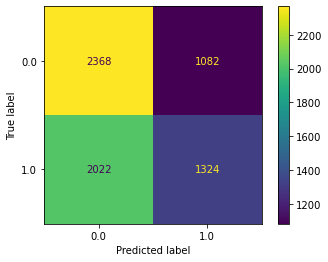

In [37]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(neigh, X_test, Y_test)  
plt.show()